# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

54612


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc
import numpy as np

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')

Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v2\Nuclear_organization_v2\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')


# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _ticklabel_size,_ticklabel_width

import seaborn as sns
sns.set_context("paper", rc={"font.size":_font_size,"axes.titlesize":_font_size+1,"axes.labelsize":_font_size})   

In [6]:
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]

celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}



# 2. Load codebook and chr2Zxys

## Codebook

Example of [codebook](../../postanalysis/0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\postanalysis_vCW2_sorted'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


# 3. Chromosome distribution of histone marks

## Load histone marks summary


 Data can be generated by the notebook:

 [0_locus_annotation/scripts/6_subclass_pairtags_means_by_loci_more_res](../0_locus_annotation/scripts/6_subclass_pairtags_means_by_loci_more_res.ipynb)

In [8]:
import tqdm

rna_summary_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v1\Nuclear_organization\analysis\analysis'

sel_class_list =celltype_palette.keys()


ref_measure_dict_byGroup = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(rna_summary_folder,f'subclass_{_class_name}_pairtag_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=1)
        ref_measure_dict_byGroup[_class] = rna_atac_df

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 71.37it/s]


In [9]:
ref_measure_dict_byGroup['L2/3 IT']

,Unnamed: 0,mean_H3K9me3_2X_2000kb,mean_H3K27me3_2X_2000kb,mean_H3K27ac_2X_2000kb,mean_H3K4me3_2X_2000kb
loci_name,,,,,
chr1_3742742_3759944,0,3.596887,0.717670,1.176722,0.0
chr1_6245958_6258969,1,6.527626,1.332675,1.262035,0.0
chr1_8740008_8759916,2,5.540078,1.168806,1.879951,0.0
chr1_9627926_9637875,3,5.129961,0.919052,1.827544,0.0
chr1_9799472_9811359,4,4.866926,0.908193,1.826935,0.0
...,...,...,...,...,...
chrX_166247682_166259932,1977,2.461479,0.708786,2.070689,0.0
chrX_167157164_167167452,1978,2.506615,0.649556,2.068251,0.0
chrX_168746045_168757590,1979,1.870039,0.467917,1.492992,0.0


In [10]:
ref_measure_dict_byGroup['L4/5 IT']

,Unnamed: 0,mean_H3K9me3_2X_2000kb,mean_H3K27me3_2X_2000kb,mean_H3K27ac_2X_2000kb,mean_H3K4me3_2X_2000kb
loci_name,,,,,
chr1_3742742_3759944,0,2.271961,0.503195,1.086957,0.086957
chr1_6245958_6258969,1,4.150421,0.929712,1.092754,0.347826
chr1_8740008_8759916,2,3.878460,0.650160,1.438647,0.434783
chr1_9627926_9637875,3,3.486161,0.482428,1.414493,0.347826
chr1_9799472_9811359,4,3.268351,0.456869,1.413527,0.347826
...,...,...,...,...,...
chrX_166247682_166259932,1977,1.606498,0.509585,1.640580,0.217391
chrX_167157164_167167452,1978,1.630566,0.496805,1.543961,0.173913
chrX_168746045_168757590,1979,1.206980,0.439297,1.159420,0.130435


# 4. Load summarized radial position

Data can be generated by the notebook

[1_radial_position_convexhull_singlecell_dataframe](1_radial_position_convexhull_singlecell_dataframe.ipynb)

In [11]:
min_pts_th = 600
output_fname = os.path.join(output_analysis_folder, f'radial_pos_convexhull_median_summary_{min_pts_th}pts_bysubclass_v2.csv')

sorted_median_radial_pos_all = pd.read_csv(output_fname, index_col=0)
sorted_median_radial_pos_all.head()

,chr,chr_order,norm_radial_position,total_cell,subclass
loci_name,,,,,
chr1_3742742_3759944,1,0,0.860136,1022.0,L2/3 IT
chr1_6245958_6258969,1,1,0.855358,969.0,L2/3 IT
chr1_8740008_8759916,1,2,0.850017,628.0,L2/3 IT
chr1_9627926_9637875,1,3,0.839728,960.0,L2/3 IT
chr1_9799472_9811359,1,4,0.826204,900.0,L2/3 IT


# 5. Load RNA and ATAC 


 Data can be generated by the notebook:

 [0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci](../0_locus_annotation/scripts/4_subclass_atac_and_rna_means_by_loci.ipynb)

In [12]:
import tqdm

rna_summary_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v1\AB_compartment\analysis'

sel_class_list =celltype_palette.keys()


ref_measure_dict_byGroup_rna = {}

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_atac_fname = os.path.join(rna_summary_folder,f'subclass_{_class_name}_snATAC_snRNA_mean_by_loci.csv')
    if os.path.exists(rna_atac_fname):
        rna_atac_df = pd.read_csv(rna_atac_fname,index_col=1)
        ref_measure_dict_byGroup_rna[_class] = rna_atac_df

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:00<00:00, 61.92it/s]


In [13]:
rna_atac_df.head()
#len(rna_atac_df)

,Unnamed: 0,mean_rna_2X_2000kb,mean_rna_2X_200kb,mean_rna_2X_50kb
loci_name,,,,
chr1_3742742_3759944,0,14.736264,12.552198,0.000000
chr1_6245958_6258969,1,5.254579,1.544872,1.544872
chr1_8740008_8759916,2,28.511905,0.000000,0.000000
chr1_9627926_9637875,3,33.426740,0.657509,0.000000
chr1_9799472_9811359,4,33.426740,0.854396,0.163004


# 6. Convert to summary df

In [14]:
#rna_summary_df = pd.DataFrame(index = rna_df_dict['L2/3 IT'].index)

target_mode_list = ['H3K9me3','H3K27me3','H3K27ac','H3K4me3',]
rna_mode_list = ['rna','ATAC']

rna_summary_dict = {'H3K9me3':[],'H3K27me3':[],'H3K27ac':[],'H3K4me3':[], 'rna':[], 'ATAC':[], 
                    'loci':[],'celltype':[],'chr':[],'norm_radial_position':[],'total_cell':[],}
for _group, _rna_df in ref_measure_dict_byGroup.items():
    #rna_summary_dict['rna'].extend(_rna_df['log10p_mean_rna'].tolist())
    #rna_summary_dict['rna'].extend(_rna_df['mean_rna'].tolist())
    for target_mode in target_mode_list:
        if f'mean_{target_mode}_2X_2000kb' in _rna_df.columns:
            rna_summary_dict[target_mode].extend(_rna_df[f'mean_{target_mode}_2X_2000kb'].tolist())
        else:
            rna_summary_dict[target_mode].extend([np.nan]*len(_rna_df))
            
    for rna_mode in rna_mode_list:
        if _group in ref_measure_dict_byGroup_rna.keys():
            _rna_df_2 = ref_measure_dict_byGroup_rna[_group]
            if f'mean_{rna_mode}_2X_2000kb' in _rna_df_2.columns:
                rna_summary_dict[rna_mode].extend(_rna_df_2[f'mean_{rna_mode}_2X_2000kb'].tolist())
            else:
                rna_summary_dict[rna_mode].extend([np.nan]*len(_rna_df))
        else:
            rna_summary_dict[rna_mode].extend([np.nan]*len(_rna_df))
                
    rna_summary_dict['loci'].extend(_rna_df.index.tolist())
    rna_summary_dict['celltype'].extend([_group]*len(_rna_df))
    rna_summary_dict['chr'].extend([i.split('_')[0] for i in _rna_df.index.tolist()])
    
    group_radial_pos_all = sorted_median_radial_pos_all[sorted_median_radial_pos_all['subclass']==_group]
    if len(group_radial_pos_all)==len(_rna_df):
        group_radial_pos_all = group_radial_pos_all.loc[_rna_df.index]
        radial_pos_list = group_radial_pos_all['norm_radial_position'].tolist()
        radial_N_list = group_radial_pos_all['total_cell'].tolist()
    else:
        radial_pos_list = [np.nan]*len(_rna_df)
        radial_N_list = [np.nan]*len(_rna_df)
        
    rna_summary_dict['norm_radial_position'].extend(radial_pos_list)
    rna_summary_dict['total_cell'].extend(radial_N_list)
    
    
rna_summary_df = pd.DataFrame(rna_summary_dict)
rna_summary_df

,H3K9me3,H3K27me3,H3K27ac,H3K4me3,rna,ATAC,loci,celltype,chr,norm_radial_position,total_cell
0,2.528736,0.571429,0.739910,0.332378,9.202454,1.459956,chr1_3742742_3759944,Astro,chr1,0.831239,1020.0
1,3.731801,0.688312,1.001495,0.491404,11.447853,1.840378,chr1_6245958_6258969,Astro,chr1,0.785055,807.0
2,3.189655,0.370130,1.028401,0.451289,6.288344,1.721496,chr1_8740008_8759916,Astro,chr1,0.836495,563.0
3,3.017241,0.441558,1.678625,0.464183,13.969325,2.377364,chr1_9627926_9637875,Astro,chr1,0.764242,826.0
4,3.040230,0.428571,1.686099,0.465616,13.969325,2.404199,chr1_9799472_9811359,Astro,chr1,0.750467,770.0
...,...,...,...,...,...,...,...,...,...,...,...
29725,3.069597,0.398438,2.511182,0.542373,4.638298,3.894289,chrX_166247682_166259932,Sst,chrX,0.812094,127.0
29726,3.304029,0.460938,2.523962,0.576271,30.595154,3.993115,chrX_167157164_167167452,Sst,chrX,0.786706,140.0
29727,2.421245,0.429688,2.019169,0.406780,28.309693,3.512353,chrX_168746045_168757590,Sst,chrX,0.777460,127.0
29728,1.772894,0.281250,1.009585,0.169492,27.760047,1.829081,chrX_169963295_170005197,Sst,chrX,0.782206,192.0


# 7. Visualize across chromosomes

# 8. Correlate and compare modality and radial for one neuron

In [15]:
from scipy.stats import linregress, pearsonr, spearmanr

## Load MeCP2

Data can be inspected from the notebook as

[external/scripts/mecp2_chip/1_inspect_chip_signal_from_Rube_2016_4mb](../../external/scripts/mecp2_chip/1_inspect_chip_signal_from_Rube_2016_4mb.ipynb)


See data of [MeCP2_ChIP](../../external/resources/GSE71126_MeCP2_ChiP_signal_4Mb.csv) in this repository

In [16]:
import tqdm

MeCP2_summary_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\MeCP2_ChiP\ChiP_results'

MeCP2_df = pd.read_csv(os.path.join(MeCP2_summary_folder, 'GSE71126_MeCP2_ChiP_signal_4Mb.csv'), index_col=0)

MeCP2_df = MeCP2_df.groupby(by='corresponding_loci').mean()
codebook_df_MeCP2 = codebook_df[['chr','chr_order']]
codebook_df_MeCP2.loc[:,MeCP2_df.columns]=MeCP2_df

mean_signal = np.mean(codebook_df_MeCP2['MeCP2_signal'])
std_signal = np.std(codebook_df_MeCP2['MeCP2_signal'])
codebook_df_MeCP2['z_score'] = (codebook_df_MeCP2['MeCP2_signal']-mean_signal)/std_signal

codebook_df_MeCP2

C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_54612\991747576.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  MeCP2_df = MeCP2_df.groupby(by='corresponding_loci').mean()
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_54612\991747576.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  codebook_df_MeCP2.loc[:,MeCP2_df.columns]=MeCP2_df
C:\Users\shiwei\AppData\Local\Temp\2\ipykernel_54612\991747576.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

,chr,chr_order,start,end,Input_count,MeCP2_count,MeCP2_signal,z_score
loci_name,,,,,,,,
chr1_3742742_3759944,1,0,1000001.0,5000000.0,877755.0,866459.0,-0.018687,-1.162028
chr1_6245958_6258969,1,1,4000001.0,8000000.0,1634519.0,1732543.0,0.084025,-1.067752
chr1_8740008_8759916,1,2,6000001.0,10000000.0,1532815.0,1677159.0,0.129836,-1.025704
chr1_9627926_9637875,1,3,7000001.0,11000000.0,1537072.0,1756953.0,0.192891,-0.967827
chr1_9799472_9811359,1,4,7000001.0,11000000.0,1537072.0,1756953.0,0.192891,-0.967827
...,...,...,...,...,...,...,...,...
chrX_166247682_166259932,X,60,164000001.0,168000000.0,575071.0,484149.0,-0.248289,-1.372773
chrX_167157164_167167452,X,61,165000001.0,169000000.0,580456.0,434359.0,-0.418299,-1.528820
chrX_168746045_168757590,X,62,166000001.0,170000000.0,699182.0,895812.0,0.357528,-0.816712


## Check correlation

### L5 ET

In [17]:
select_chroms_plot = [str(i) for i in range(1,20)]
select_chroms_plot.append('X')

sel_celltype = 'L5 ET'

#rna_col = 'rna_2000kb'
radial_activity_summary_dict = {'chr':[],'celltype':[],'target_mode':[], 'spearman_r':[], }
for rna_col in ['H3K9me3','H3K27me3','H3K27ac','H3K4me3','rna','ATAC']:
    for sel_chrom in select_chroms_plot:
        plot_df = rna_summary_df[rna_summary_df['chr']==f'chr{sel_chrom}']

        sel_plot_df = plot_df[plot_df['celltype']==sel_celltype]
        r_value = spearmanr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
        radial_activity_summary_dict['spearman_r'].append(r_value[0])
        #r_value = pearsonr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
        #radial_activity_summary_dict['pearson_r'].append(r_value[0])

        radial_activity_summary_dict['chr'].append(sel_chrom)
        radial_activity_summary_dict['celltype'].append(sel_celltype)
        radial_activity_summary_dict['target_mode'].append(rna_col)
        
# add MeCP2
for sel_chrom in select_chroms_plot:
    sel_codebook_df_MeCP2 = codebook_df_MeCP2[codebook_df_MeCP2['chr']==sel_chrom]
    
    plot_df = rna_summary_df[rna_summary_df['chr']==f'chr{sel_chrom}']

    sel_plot_df = plot_df[plot_df['celltype']==sel_celltype]
    x = np.array(sel_codebook_df_MeCP2['z_score'])
    y = np.array(sel_plot_df['norm_radial_position'])
    x_good = x[(~np.isnan(x)) & (~np.isnan(y))]
    y_good = y[(~np.isnan(x)) & (~np.isnan(y))]
    r_value = spearmanr(x_good,y_good)
    radial_activity_summary_dict['spearman_r'].append(r_value[0])
    #r_value = pearsonr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
    #radial_activity_summary_dict['pearson_r'].append(r_value[0])

    radial_activity_summary_dict['chr'].append(sel_chrom)
    radial_activity_summary_dict['celltype'].append(sel_celltype)
    radial_activity_summary_dict['target_mode'].append('MeCP2')


radial_activity_summary_df = pd.DataFrame(radial_activity_summary_dict)
radial_activity_summary_df['spearman_r_abs']=abs(radial_activity_summary_df['spearman_r'])
radial_activity_summary_df.head()

,chr,celltype,target_mode,spearman_r,spearman_r_abs
0,1,L5 ET,H3K9me3,0.293408,0.293408
1,2,L5 ET,H3K9me3,0.385393,0.385393
2,3,L5 ET,H3K9me3,0.225430,0.225430
3,4,L5 ET,H3K9me3,0.456154,0.456154
4,5,L5 ET,H3K9me3,0.016814,0.016814


In [18]:
np.unique(radial_activity_summary_df['target_mode'])

array(['ATAC', 'H3K27ac', 'H3K27me3', 'H3K4me3', 'H3K9me3', 'MeCP2',
       'rna'], dtype=object)

meta NOT subset; don't know how to subset; dropped


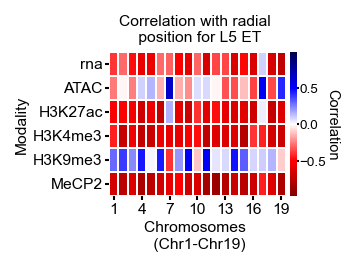

In [19]:

#sel_mode = 'H3K9me3'
sel_radial_activity_summary_df = radial_activity_summary_df.copy(deep=True)

radial_activity_mat = sel_radial_activity_summary_df.pivot(index='target_mode',columns='chr',values='spearman_r')
sorted_chroms = [str(i) for i in range(1,20)]
#sorted_chroms.append('X')
radial_activity_mat = radial_activity_mat[sorted_chroms]
#sorted_chroms = [str(i) for i in range(1,20)]
#sorted_chroms.append('X')
sorted_mode_list = ['rna', 'ATAC', 'H3K27ac', 'H3K4me3',
                    #'H3K27me3',
                    'H3K9me3', 'MeCP2',
                   ]
radial_activity_mat = radial_activity_mat.transpose()
radial_activity_mat = radial_activity_mat[sorted_mode_list]
radial_activity_mat = radial_activity_mat.transpose()

# remove bad quality data for the selected celltype
#radial_activity_mat.loc['H3K4me3',:]=np.nan

#cmap = sns.cm.rocket
cmap = plt.get_cmap('seismic_r')
cmap.set_bad(color = 'gray', alpha = 0.65)

fig,ax=plt.subplots(figsize=(_page_width/3,_font_size/6),dpi=150)

#cbar_kws = dict(pad=.02)
#boxprops = dict(linecolor='black')
gfg = sns.heatmap(data=radial_activity_mat, #hue="chr",
                  #order=selected_cell_labels,
                  #hue_order=box_palette.keys(),
            ax=ax, cmap=cmap, vmin = -0.99, vmax = 0.99,
                  cbar_kws={'label':'Correlation', "pad": 0.02},linewidth=0.01,
             )

ax.set_xlabel(f"Chromosomes \n (Chr1-Chr19)", fontsize=_font_size, rotation=0,labelpad=2,)
ax.set_ylabel(f"Modality", fontsize=_font_size, rotation=90,labelpad=2,)
ax.tick_params('both',labelsize=_font_size,length=_ticklabel_size,pad=1, )
ax.figure.axes[-1].tick_params(axis='y', length=1, pad=0.1, labelsize=_font_size-1,rotation=0,)
ax.figure.axes[-1].set_ylabel('Correlation', fontsize=_font_size-0.5, rotation=270, labelpad=6)
plt.xticks(rotation=0)
#plt.xlim([-1,20])
#plt.ylim([-0.8,0.2])
#select_chroms_plot = [str(i) for i in range(1,20)]
#select_chroms_plot.append('X')
#ax.set_xticks(np.arange(0,len(select_chroms_plot)))
#TickLabels = select_chroms_plot
#ax.set_xticklabels(TickLabels,rotation=0,fontdict={'fontsize':10})
#ax.axhline(0.7, 0, 20, color='crimson', linestyle='dashed', linewidth=1.5)
ax.grid(False)
ax.set_title(f'Correlation with radial \n position for {sel_celltype}', fontsize=_font_size, pad=5)

sel_celltype = sel_celltype.replace('/','_')
#ax.set_yticklabels(TickLabels,rotation=0,fontdict={'fontsize':12})
plt.savefig(os.path.join(output_figure_folder, f'Corr_of_radial_and_multi_mode_matrix_{sel_celltype}_Reverse.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight') 
plt.show()

### L2/3 IT

In [20]:
select_chroms_plot = [str(i) for i in range(1,20)]
select_chroms_plot.append('X')

sel_celltype = 'L2/3 IT'

#rna_col = 'rna_2000kb'
radial_activity_summary_dict = {'chr':[],'celltype':[],'target_mode':[], 'spearman_r':[], }
for rna_col in ['H3K9me3','H3K27me3','H3K27ac','H3K4me3','rna','ATAC']:
    for sel_chrom in select_chroms_plot:
        plot_df = rna_summary_df[rna_summary_df['chr']==f'chr{sel_chrom}']

        sel_plot_df = plot_df[plot_df['celltype']==sel_celltype]
        r_value = spearmanr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
        radial_activity_summary_dict['spearman_r'].append(r_value[0])
        #r_value = pearsonr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
        #radial_activity_summary_dict['pearson_r'].append(r_value[0])

        radial_activity_summary_dict['chr'].append(sel_chrom)
        radial_activity_summary_dict['celltype'].append(sel_celltype)
        radial_activity_summary_dict['target_mode'].append(rna_col)
        
# add MeCP2
for sel_chrom in select_chroms_plot:
    sel_codebook_df_MeCP2 = codebook_df_MeCP2[codebook_df_MeCP2['chr']==sel_chrom]
    
    plot_df = rna_summary_df[rna_summary_df['chr']==f'chr{sel_chrom}']

    sel_plot_df = plot_df[plot_df['celltype']==sel_celltype]
    x = np.array(sel_codebook_df_MeCP2['z_score'])
    y = np.array(sel_plot_df['norm_radial_position'])
    x_good = x[(~np.isnan(x)) & (~np.isnan(y))]
    y_good = y[(~np.isnan(x)) & (~np.isnan(y))]
    r_value = spearmanr(x_good,y_good)
    radial_activity_summary_dict['spearman_r'].append(r_value[0])
    #r_value = pearsonr(sel_plot_df[rna_col],sel_plot_df['norm_radial_position'])
    #radial_activity_summary_dict['pearson_r'].append(r_value[0])

    radial_activity_summary_dict['chr'].append(sel_chrom)
    radial_activity_summary_dict['celltype'].append(sel_celltype)
    radial_activity_summary_dict['target_mode'].append('MeCP2')


radial_activity_summary_df = pd.DataFrame(radial_activity_summary_dict)
radial_activity_summary_df['spearman_r_abs']=abs(radial_activity_summary_df['spearman_r'])
radial_activity_summary_df.head()

,chr,celltype,target_mode,spearman_r,spearman_r_abs
0,1,L2/3 IT,H3K9me3,0.417263,0.417263
1,2,L2/3 IT,H3K9me3,0.341023,0.341023
2,3,L2/3 IT,H3K9me3,0.260393,0.260393
3,4,L2/3 IT,H3K9me3,0.478829,0.478829
4,5,L2/3 IT,H3K9me3,0.045364,0.045364


meta NOT subset; don't know how to subset; dropped


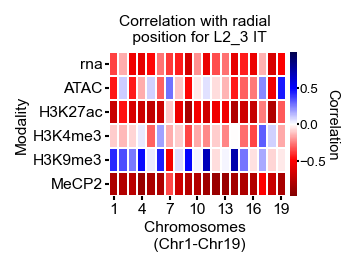

In [22]:

#sel_mode = 'H3K9me3'
sel_radial_activity_summary_df = radial_activity_summary_df.copy(deep=True)

radial_activity_mat = sel_radial_activity_summary_df.pivot(index='target_mode',columns='chr',values='spearman_r')
sorted_chroms = [str(i) for i in range(1,20)]
#sorted_chroms.append('X')
radial_activity_mat = radial_activity_mat[sorted_chroms]
#sorted_chroms = [str(i) for i in range(1,20)]
#sorted_chroms.append('X')
sorted_mode_list = ['rna', 'ATAC', 'H3K27ac', 'H3K4me3',
                    #'H3K27me3',
                    'H3K9me3', 'MeCP2',
                   ]
radial_activity_mat = radial_activity_mat.transpose()
radial_activity_mat = radial_activity_mat[sorted_mode_list]
radial_activity_mat = radial_activity_mat.transpose()

# remove bad quality data for the selected celltype
#radial_activity_mat.loc['H3K4me3',:]=np.nan

#cmap = sns.cm.rocket
cmap = plt.get_cmap('seismic_r')
cmap.set_bad(color = 'gray', alpha = 0.65)

fig,ax=plt.subplots(figsize=(_page_width/3,_font_size/6),dpi=150)

#cbar_kws = dict(pad=.02)
#boxprops = dict(linecolor='black')
gfg = sns.heatmap(data=radial_activity_mat, #hue="chr",
                  #order=selected_cell_labels,
                  #hue_order=box_palette.keys(),
            ax=ax, cmap=cmap, vmin = -0.99, vmax = 0.99,
                  cbar_kws={'label':'Correlation', "pad": 0.02},linewidth=0.01,
             )

ax.set_xlabel(f"Chromosomes \n (Chr1-Chr19)", fontsize=_font_size, rotation=0,labelpad=2,)
ax.set_ylabel(f"Modality", fontsize=_font_size, rotation=90,labelpad=2,)
ax.tick_params('both',labelsize=_font_size,length=_ticklabel_size,pad=1, )
ax.figure.axes[-1].tick_params(axis='y', length=1, pad=0.1, labelsize=_font_size-1,rotation=0,)
ax.figure.axes[-1].set_ylabel('Correlation', fontsize=_font_size-0.5, rotation=270, labelpad=6)
plt.xticks(rotation=0)
#plt.xlim([-1,20])
#plt.ylim([-0.8,0.2])
#select_chroms_plot = [str(i) for i in range(1,20)]
#select_chroms_plot.append('X')
#ax.set_xticks(np.arange(0,len(select_chroms_plot)))
#TickLabels = select_chroms_plot
#ax.set_xticklabels(TickLabels,rotation=0,fontdict={'fontsize':10})
#ax.axhline(0.7, 0, 20, color='crimson', linestyle='dashed', linewidth=1.5)
ax.grid(False)
ax.set_title(f'Correlation with radial \n position for {sel_celltype}', fontsize=_font_size, pad=5)

sel_celltype = sel_celltype.replace('/','_')
#ax.set_yticklabels(TickLabels,rotation=0,fontdict={'fontsize':12})
plt.savefig(os.path.join(output_figure_folder, f'Corr_of_radial_and_multi_mode_matrix_{sel_celltype}_Reverse.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight') 
plt.show()

## Visualize along chromosomes

In [ ]:
%matplotlib inline
#plt.style.use('default')
from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size

# min num of cells to include for plot
min_cell_th = 100
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT',
                        #'L5 ET','L6 CT',
                        'Oligo', 'Astro'][:]


sel_celltype = 'L5 ET'
#colors = [celltype_palette[_c] for _c in selected_cell_labels]
# Use for sorting chromosome by number (from PZ)
def sort_mouse_chr(_chr):
    _chr = _chr.split('chr')[-1]
    try:
        out_key = int(_chr)
    except:
        if _chr == 'X':
            out_key = 20
        elif _chr == 'Y':
            out_key = 21
    return out_key


df_plot = rna_summary_df[rna_summary_df['celltype']==sel_celltype]
df_plot['Radial'] = df_plot['norm_radial_position'] # copy
df_plot = df_plot[(df_plot['chr']!='chrY') & (df_plot['chr']!='chrX')] # remove chrX for MeCP2
df_plot['chr_num'] = df_plot['chr'].apply(lambda x: sort_mouse_chr(x))
# add MeCP2
sel_codebook_df_MeCP2 = codebook_df_MeCP2[~codebook_df_MeCP2['chr'].isin(['X','Y'])] # remove chrX for MeCP2
df_plot['MeCP2'] = sel_codebook_df_MeCP2['z_score'].tolist()
import tqdm
#rna_col = 'H3K9me3'

for rna_col in ['rna', 'ATAC', 'H3K27ac', 'H3K4me3',
                    #'H3K27me3',
                    'H3K9me3', 'MeCP2','Radial',
                   ]:

    
    fig = plt.figure(figsize=(_page_width/1.2,0.1), dpi=100)

    if rna_col in ['rna','ATAC']:
        df_plot[f'log10_{rna_col}'] = np.log10(df_plot[rna_col]+.01)
    else:
        df_plot[f'log10_{rna_col}'] = df_plot[rna_col]
        
    atac_all_chr = df_plot[f'log10_{rna_col}'].tolist()
    if rna_col=='MeCP2':
        atac_all_chr_check = atac_all_chr
        

    gs = fig.add_gridspec(nrows=1, ncols=len(df_plot)+360, left=0.05, right=0.75,
                          hspace=0.1)

    plotted_chr = 0
    plot_col_tracker = 0

    plot_chr_names = [str(i) for i in range(1,20)]
    plot_chr_names.append('X')
    
    if rna_col in ['H3K9me3','MeCP2']:
        rna_vmin, rna_vmax = np.nanpercentile(atac_all_chr, 70), np.nanpercentile(atac_all_chr, 95)
        cmap='Blues' # enriched site
    elif rna_col in ['Radial']:
        rna_vmin, rna_vmax = np.nanpercentile(atac_all_chr, 3), np.nanpercentile(atac_all_chr, 35)
        cmap='Greens_r' # lower radial sites
    #else:
        #rna_vmin, rna_vmax = np.nanpercentile(atac_all_chr, 5), np.nanpercentile(atac_all_chr, 35)
        #cmap='Reds_r'
    else:
        rna_vmin, rna_vmax = np.nanpercentile(atac_all_chr, 70), np.nanpercentile(atac_all_chr, 95)
        cmap='Reds' # enriched site

    for chr_num, df_chr in df_plot.groupby('chr_num'):
        if chr_num==plotted_chr+1:
            plotted_chr+=1 # keep track of the chromosomes

            ax = fig.add_subplot(gs[0, plot_col_tracker:plot_col_tracker+len(df_chr)])
            plot_col_tracker += len(df_chr)+20

            sns.heatmap(df_chr[f'log10_{rna_col}'].values.reshape(1, len(df_chr)), 
                        vmin=rna_vmin, vmax=rna_vmax, cmap=cmap,  #center=1.5,#alpha=0.1,
                       xticklabels=False, yticklabels=False, cbar=False)


            ax.set_xticks([int(len(df_chr)/2)],[chr_num])
            ax.tick_params(axis='x', top=True, labeltop=True, bottom=False, labelbottom=False)
            ax.spines['top'].set_visible(True)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)
            ax.spines['bottom'].set_visible(True)
            
            if chr_num==1:
                ax.set_title(rna_col)
        
    #_class = _class.replace('/','_').replace(' ','_')

    plt.savefig(os.path.join(output_figure_folder, f'{rna_col}_along_allchrom_across_{sel_celltype}_enrichedment.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')
    plt.show()